#LSTM and ARIMA with Parabolic SAR technical indicator


**Students:** Gabriel Sposito and Thomas Frentzel

**LSTM**


In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=a4d303c3ca41949833602dddfa5ccda8bb86fcf95b1c5ffaaae6d625621f624f
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from ta.trend import CCIIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import PSARIndicator

In [3]:
base = pd.read_csv('NVDA 5Y.csv')
base.head()

,Date,Close/Last,Volume,Open,High,Low
0,10/08/2024,$132.89,285722500,$130.26,$133.48,$129.42
1,10/07/2024,$127.72,346250200,$124.99,$130.64,$124.95
2,10/04/2024,$124.92,244465600,$124.94,$125.04,$121.83
3,10/03/2024,$122.85,277118000,$120.92,$124.36,$120.3401
4,10/02/2024,$118.85,221845900,$116.44,$119.38,$115.14


In [4]:
# Removing nule results
base.dropna()

,Date,Close/Last,Volume,Open,High,Low
0,10/08/2024,$132.89,285722500,$130.26,$133.48,$129.42
1,10/07/2024,$127.72,346250200,$124.99,$130.64,$124.95
2,10/04/2024,$124.92,244465600,$124.94,$125.04,$121.83
3,10/03/2024,$122.85,277118000,$120.92,$124.36,$120.3401
4,10/02/2024,$118.85,221845900,$116.44,$119.38,$115.14
...,...,...,...,...,...,...
1253,10/15/2019,$4.9093,667985200,$4.754,$4.9823,$4.74
1254,10/14/2019,$4.6633,210335760,$4.641,$4.6843,$4.6096
1255,10/11/2019,$4.6498,450866800,$4.6603,$4.7335,$4.6413
1256,10/10/2019,$4.5758,327515560,$4.5155,$4.627,$4.5103


In [5]:
# Removing $
base['Close/Last'] = base['Close/Last'].str.replace('$', '')
base['Open'] = base['Open'].str.replace('$', '')
base['High'] = base['High'].str.replace('$', '')
base['Low'] = base['Low'].str.replace('$', '')

# Converting str to float
base['Close/Last'] = base['Close/Last'].astype(float)
base['Open'] = base['Open'].astype(float)
base['High'] = base['High'].astype(float)
base['Low'] = base['Low'].astype(float)

In [6]:
cci = CCIIndicator(high=base['High'], low=base['Low'], close=base['Close/Last'], window=20, constant=0.015)
base['CCI'] = cci.cci()

sma_tp = base['High'] + base['Low'] + base['Close/Last'] / 3
sma_tp = sma_tp.rolling(window=20).mean()
mean_deviation = np.mean(np.abs(base['Close/Last'] - sma_tp))

rsi = RSIIndicator(close=base['Close/Last'], window=14)
base['RSI'] = rsi.rsi()

macd = MACD(close=base['Close/Last'], window_slow=26, window_fast=12, window_sign=9)
base['MACD'] = macd.macd()
base['MACD_Signal'] = macd.macd_signal()
base['MACD_Diff'] = macd.macd_diff()

psar = PSARIndicator(high=base['High'], low=base['Low'], close=base['Close/Last'])
base['Parabolic_SAR'] = psar.psar()

bollinger = BollingerBands(close=base['Close/Last'], window=20, window_dev=2)
base['Bollinger_High'] = bollinger.bollinger_hband()
base['Bollinger_Low'] = bollinger.bollinger_lband()
base['Bollinger_Middle'] = bollinger.bollinger_mavg()
base['Bollinger_Width'] = bollinger.bollinger_wband()

base.dropna()

,Date,Close/Last,Volume,Open,High,Low,CCI,RSI,MACD,MACD_Signal,MACD_Diff,Parabolic_SAR,Bollinger_High,Bollinger_Low,Bollinger_Middle,Bollinger_Width
33,08/21/2024,128.5000,257883600,127.3150,129.3500,126.6600,109.563550,59.206678,1.479949,-0.959813,2.439762,115.264796,133.280229,100.584771,116.932500,27.960967
34,08/20/2024,127.2500,300087400,128.4000,129.8800,125.8900,93.439821,57.552758,1.795072,-0.408836,2.203908,117.184220,134.480982,100.772018,117.626500,28.657628
35,08/19/2024,130.0000,318333600,124.2800,130.0000,123.4200,85.454132,60.187685,2.240879,0.121107,2.119773,118.873314,136.004529,100.689471,118.347000,29.840264
36,08/16/2024,124.5800,302589900,121.9400,125.0000,121.1800,43.621331,53.180795,2.132257,0.523337,1.608920,120.359716,136.582416,100.891584,118.737000,30.058729
37,08/15/2024,122.8600,318086700,118.7600,123.2400,117.4700,20.947193,51.145899,1.885647,0.795799,1.089848,131.260000,136.860746,100.989254,118.925000,30.163121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,10/15/2019,4.9093,667985200,4.7540,4.9823,4.7400,-81.288448,39.738294,-0.131057,-0.128466,-0.002591,4.993934,5.343533,4.736087,5.039810,12.052969
1254,10/14/2019,4.6633,210335760,4.6410,4.6843,4.6096,-167.078542,30.794457,-0.143643,-0.131501,-0.012142,4.980500,5.347782,4.677718,5.012750,13.367186
1255,10/11/2019,4.6498,450866800,4.6603,4.7335,4.6413,-137.142137,30.390224,-0.152944,-0.135790,-0.017154,4.982300,5.344708,4.626322,4.985515,14.409444
1256,10/10/2019,4.5758,327515560,4.5155,4.6270,4.5103,-162.944078,28.204663,-0.164391,-0.141510,-0.022881,4.937576,5.339425,4.568335,4.953880,15.565376


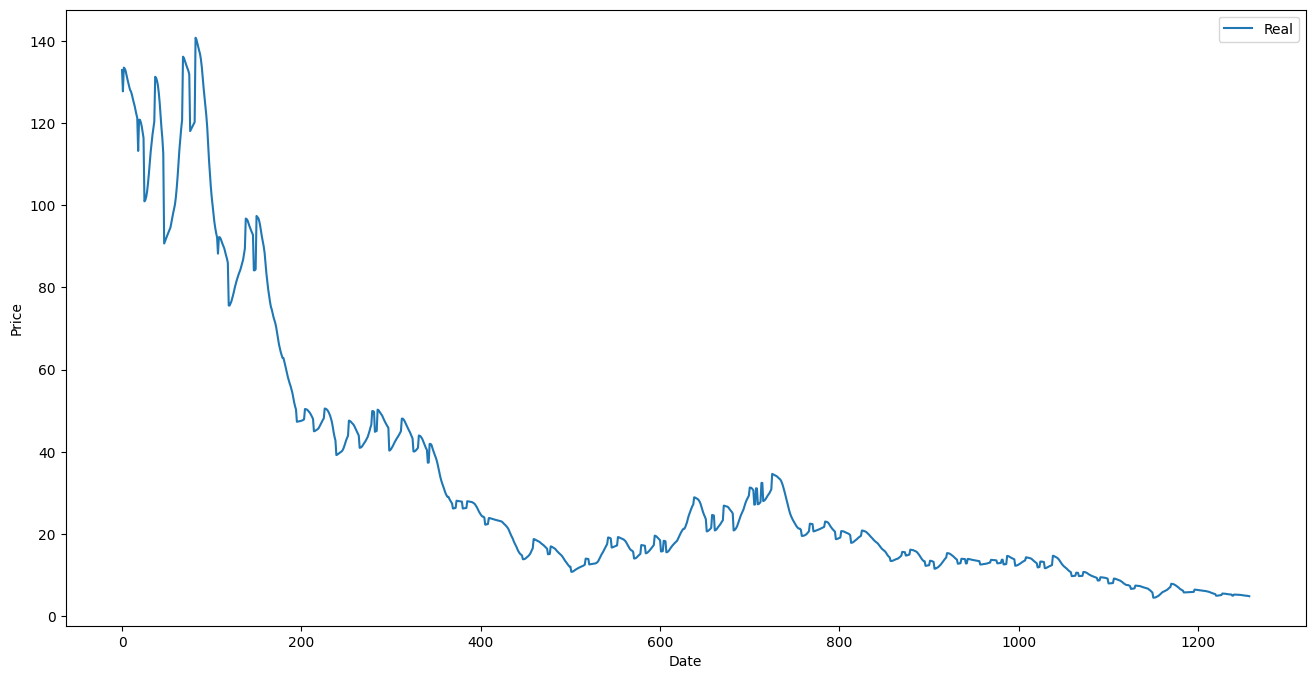

In [7]:
plt.figure(figsize=(16,8))
plt.plot(base['Parabolic_SAR'], label='Real')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

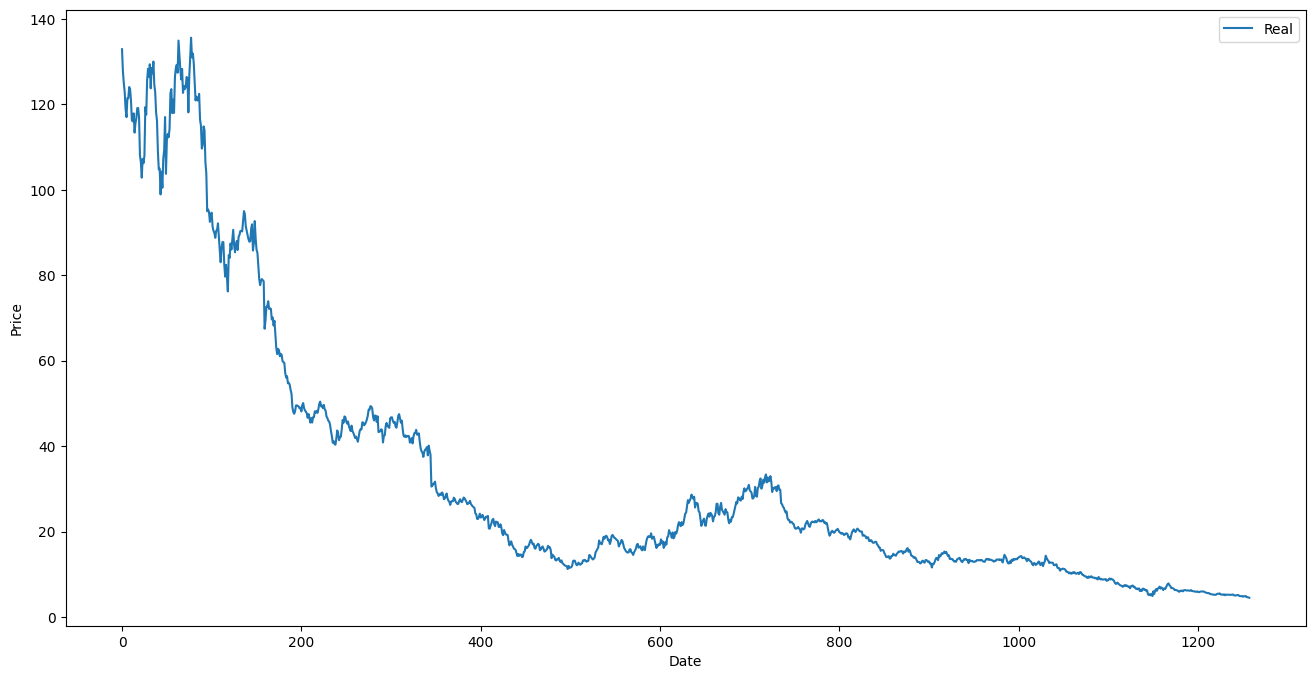

In [8]:
plt.figure(figsize=(16,8))
plt.plot(base['Close/Last'], label='Real')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [9]:
# Converting indicator values ​​to numeric values ​​and removing NaN values
base = base.replace([np.inf, -np.inf], np.nan)
base = base.dropna()

In [10]:
# Normalizing the data of real values
scaler_real_value = MinMaxScaler(feature_range=(0, 1))
scaled_data_real_value = scaler_real_value.fit_transform(np.array(base['Close/Last']).reshape(-1, 1))

In [11]:
window_size_real_value = 10
forecasters_real_value = []
real_value_of_prices = []
for i in range(window_size_real_value, len(base)):
    forecasters_real_value.append(scaled_data_real_value[i - window_size_real_value:i, 0])
    real_value_of_prices.append(scaled_data_real_value[i, 0])

forecasters_real_value, real_value_of_prices = np.array(forecasters_real_value), np.array(real_value_of_prices)
forecasters_real_value = np.reshape(forecasters_real_value, (forecasters_real_value.shape[0], forecasters_real_value.shape[1], 1))

In [12]:
#dividindo a coluna close/last em 70% treino e 30% teste com trai_test_split
Xtrain_real_lstm, Xtest_real_lstm, ytrain_real_lstm, ytest_real_lstm = train_test_split(forecasters_real_value, real_value_of_prices,
                                                                                        test_size = 0.3, shuffle = False)

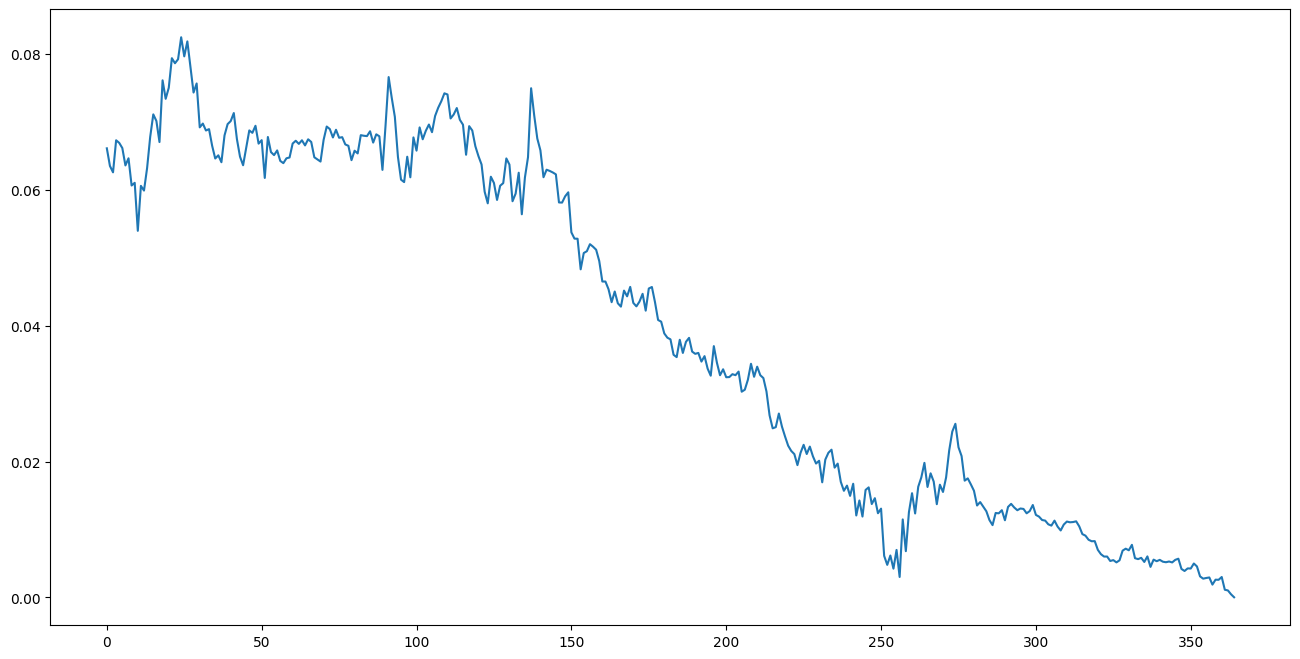

In [13]:
#plotando grafico dos valores de teste
plt.figure(figsize=(16,8))
plt.plot(ytest_real_lstm)
plt.show()

In [14]:
# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(base['Parabolic_SAR']).reshape(-1, 1))

In [15]:
window_size = 10
forecasters = []
real_value = []
for i in range(window_size, len(base)):
    forecasters.append(scaled_data[i - window_size:i, 0])
    real_value.append(scaled_data[i, 0])

forecasters, real_value = np.array(forecasters), np.array(real_value)
forecasters = np.reshape(forecasters, (forecasters.shape[0], forecasters.shape[1], 1))

In [16]:
# Separating data between training and testing
X_train, X_test, y_train, y_test = train_test_split(forecasters, real_value, test_size=0.3, shuffle=False)

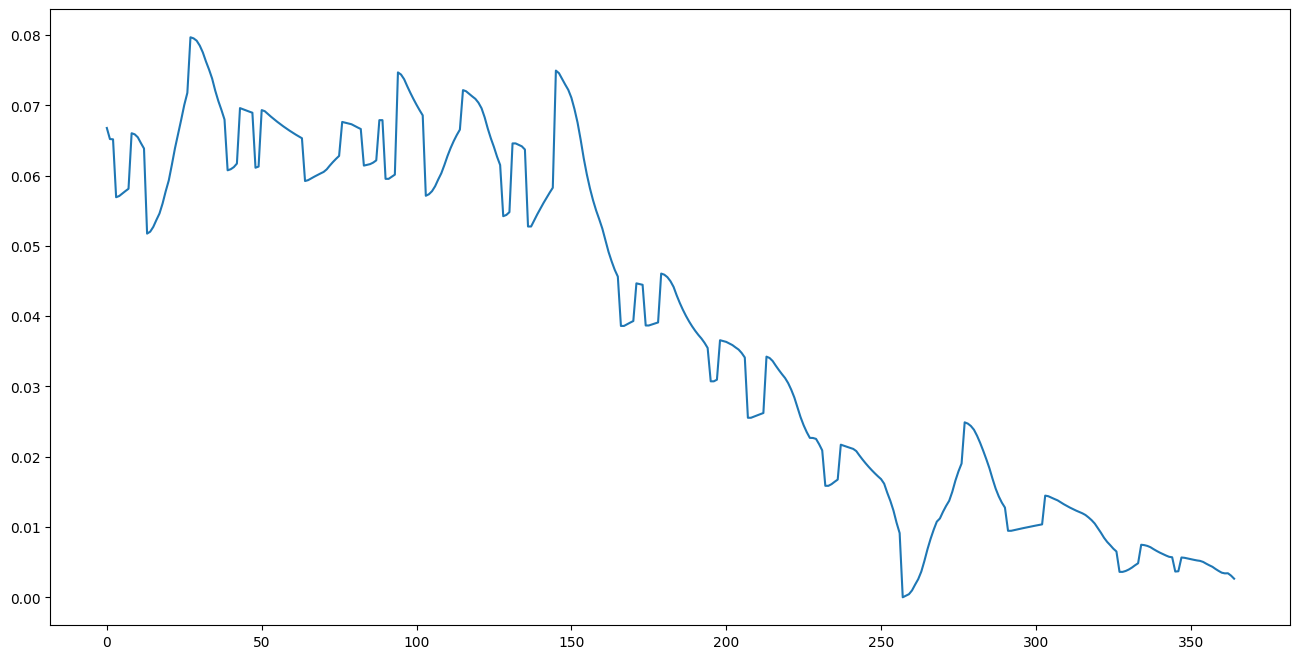

In [17]:
plt.figure(figsize=(16, 8))
plt.plot(y_test)
plt.show()

In [18]:
# LSTM model

lstm = Sequential()
lstm.add(LSTM(units=50, return_sequences=True, input_shape=(forecasters.shape[1], 1)))
lstm.add(Dropout(0.3))
lstm.add(LSTM(units=50, return_sequences=True))
lstm.add(Dropout(0.3))
lstm.add(LSTM(units=50))
lstm.add(Dropout(0.3))
lstm.add(Dense(units=1))
lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
history = lstm.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 0.0449 - mean_absolute_error: 0.1482 - val_loss: 9.4958e-04 - val_mean_absolute_error: 0.0293
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0035 - mean_absolute_error: 0.0386 - val_loss: 5.3147e-04 - val_mean_absolute_error: 0.0218
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0044 - mean_absolute_error: 0.0384 - val_loss: 3.9155e-04 - val_mean_absolute_error: 0.0185
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0035 - mean_absolute_error: 0.0360 - val_loss: 5.5433e-05 - val_mean_absolute_error: 0.0061
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0034 - mean_absolute_error: 0.0353 - val_loss: 7.1488e-05 - val_mean_absolute_error: 0.0072
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0032 - mean_absolute_error: 0.0320 - val_loss: 5.1339e-05 - val_mean_absolute_error: 0.0059
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0026 - mean_a

In [20]:
test_predictions = lstm.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


In [21]:
# Transforming test values ​​back to original values
y_orig_test = scaler.inverse_transform(y_test.reshape(-1, 1))

#escalonando valores de teste
ytest_real_lstm = scaler_real_value.inverse_transform(ytest_real_lstm.reshape(-1, 1))

In [22]:
test_predictions = test_predictions.ravel()  # Converts to 1D
y_orig_test = y_orig_test.ravel()
ytest_real_lstm = ytest_real_lstm.ravel()

In [23]:
test_size_L = len(y_test)

high_test_L = base['High'].tail(test_size_L)
low_test_L = base['Low'].tail(test_size_L)
close_test_L = base['Close/Last'].tail(test_size_L)

In [24]:
# Inverse Parabolic SAR formula
def inverse_psar(psar_values, high, low, close):
    original_prices = []

    original_prices.append(close[0])

    for i in range(1, len(psar_values)):
        if psar_values[i] < close[i-1]:
            estimated_price = close[i-1] + (close[i-1] - psar_values[i-1])
            estimated_price = min(estimated_price, high[i])
        else:
            estimated_price = close[i-1] - (psar_values[i-1] - close[i-1])
            estimated_price = max(estimated_price, low[i])

        original_prices.append(estimated_price)

    return np.array(original_prices)

# Making sure the data is in array format
high_test_L = high_test_L.values if isinstance(high_test_L, pd.Series) else high_test_L
low_test_L = low_test_L.values if isinstance(low_test_L, pd.Series) else low_test_L
close_test_L = close_test_L.values if isinstance(close_test_L, pd.Series) else close_test_L


In [25]:
# Inverting the values ​​test_predictions and y_orig_teste by the inverse Parabolic SAR formula
test_predictions_inverted = inverse_psar(test_predictions, high_test_L, low_test_L, close_test_L)
y_orig_test_inverted = inverse_psar(y_orig_test, high_test_L, low_test_L, close_test_L)

min_length = min(len(ytest_real_lstm), len(test_predictions_inverted))
ytest_real_lstm = ytest_real_lstm[:min_length]
test_predictions_inverted = test_predictions_inverted[:min_length]

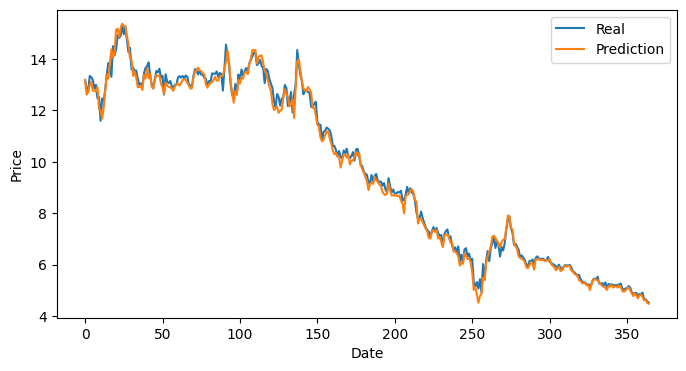

In [26]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(ytest_real_lstm)), ytest_real_lstm, label='Real')
plt.plot(range(len(test_predictions_inverted)), test_predictions_inverted, label='Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [27]:
# R2 Score
r2 = r2_score(ytest_real_lstm, test_predictions_inverted)
print(f'R2 Score: {r2}')

# RMSE
rmse = np.sqrt(np.mean((ytest_real_lstm - test_predictions_inverted) ** 2))
print(f'RMSE: {rmse}')

R2 Score: 0.9950626636733148
RMSE: 0.23653202729944964


**ARIMA**

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from ta.trend import CCIIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import PSARIndicator
from math import sqrt

In [29]:
base_A = pd.read_csv('NVDA 5Y.csv')
base_A.head()

,Date,Close/Last,Volume,Open,High,Low
0,10/08/2024,$132.89,285722500,$130.26,$133.48,$129.42
1,10/07/2024,$127.72,346250200,$124.99,$130.64,$124.95
2,10/04/2024,$124.92,244465600,$124.94,$125.04,$121.83
3,10/03/2024,$122.85,277118000,$120.92,$124.36,$120.3401
4,10/02/2024,$118.85,221845900,$116.44,$119.38,$115.14


In [30]:
base_A.dtypes

,0
Date,object
Close/Last,object
Volume,int64
Open,object
High,object
Low,object


In [31]:
# Removing $
base_A['Close/Last'] = base_A['Close/Last'].str.replace('$', '')
base_A['Open'] = base_A['Open'].str.replace('$', '')
base_A['High'] = base_A['High'].str.replace('$', '')
base_A['Low'] = base_A['Low'].str.replace('$', '')

# Converting str to float
base_A['Close/Last'] = base_A['Close/Last'].astype(float)
base_A['Open'] = base_A['Open'].astype(float)
base_A['High'] = base_A['High'].astype(float)
base_A['Low'] = base_A['Low'].astype(float)

In [32]:
cci = CCIIndicator(high=base_A['High'], low=base_A['Low'], close=base_A['Close/Last'], window=20, constant=0.015)
base_A['CCI'] = cci.cci()

sma_tp = base_A['High'] + base_A['Low'] + base_A['Close/Last'] / 3
sma_tp = sma_tp.rolling(window=20).mean()
mean_deviation = np.mean(np.abs(base_A['Close/Last'] - sma_tp))

rsi = RSIIndicator(close=base_A['Close/Last'], window=14)
base_A['RSI'] = rsi.rsi()

macd = MACD(close=base_A['Close/Last'], window_slow=26, window_fast=12, window_sign=9)
base_A['MACD'] = macd.macd()
base_A['MACD_Signal'] = macd.macd_signal()
base_A['MACD_Diff'] = macd.macd_diff()

psar = PSARIndicator(high=base_A['High'], low=base_A['Low'], close=base_A['Close/Last'])
base_A['Parabolic_SAR'] = psar.psar()

bollinger = BollingerBands(close=base_A['Close/Last'], window=20, window_dev=2)
base_A['Bollinger_High'] = bollinger.bollinger_hband()
base_A['Bollinger_Low'] = bollinger.bollinger_lband()
base_A['Bollinger_Middle'] = bollinger.bollinger_mavg()
base_A['Bollinger_Width'] = bollinger.bollinger_wband()

base_A.dropna()

,Date,Close/Last,Volume,Open,High,Low,CCI,RSI,MACD,MACD_Signal,MACD_Diff,Parabolic_SAR,Bollinger_High,Bollinger_Low,Bollinger_Middle,Bollinger_Width
33,08/21/2024,128.5000,257883600,127.3150,129.3500,126.6600,109.563550,59.206678,1.479949,-0.959813,2.439762,115.264796,133.280229,100.584771,116.932500,27.960967
34,08/20/2024,127.2500,300087400,128.4000,129.8800,125.8900,93.439821,57.552758,1.795072,-0.408836,2.203908,117.184220,134.480982,100.772018,117.626500,28.657628
35,08/19/2024,130.0000,318333600,124.2800,130.0000,123.4200,85.454132,60.187685,2.240879,0.121107,2.119773,118.873314,136.004529,100.689471,118.347000,29.840264
36,08/16/2024,124.5800,302589900,121.9400,125.0000,121.1800,43.621331,53.180795,2.132257,0.523337,1.608920,120.359716,136.582416,100.891584,118.737000,30.058729
37,08/15/2024,122.8600,318086700,118.7600,123.2400,117.4700,20.947193,51.145899,1.885647,0.795799,1.089848,131.260000,136.860746,100.989254,118.925000,30.163121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,10/15/2019,4.9093,667985200,4.7540,4.9823,4.7400,-81.288448,39.738294,-0.131057,-0.128466,-0.002591,4.993934,5.343533,4.736087,5.039810,12.052969
1254,10/14/2019,4.6633,210335760,4.6410,4.6843,4.6096,-167.078542,30.794457,-0.143643,-0.131501,-0.012142,4.980500,5.347782,4.677718,5.012750,13.367186
1255,10/11/2019,4.6498,450866800,4.6603,4.7335,4.6413,-137.142137,30.390224,-0.152944,-0.135790,-0.017154,4.982300,5.344708,4.626322,4.985515,14.409444
1256,10/10/2019,4.5758,327515560,4.5155,4.6270,4.5103,-162.944078,28.204663,-0.164391,-0.141510,-0.022881,4.937576,5.339425,4.568335,4.953880,15.565376


In [33]:
# Converting indicator values ​​to numeric values ​​and removing NaN values
base_A = base_A.replace([np.inf, -np.inf], np.nan)
base_A = base_A.dropna()

In [34]:
base_A.head()

,Date,Close/Last,Volume,Open,High,Low,CCI,RSI,MACD,MACD_Signal,MACD_Diff,Parabolic_SAR,Bollinger_High,Bollinger_Low,Bollinger_Middle,Bollinger_Width
33,08/21/2024,128.50,257883600,127.315,129.35,126.66,109.563550,59.206678,1.479949,-0.959813,2.439762,115.264796,133.280229,100.584771,116.9325,27.960967
34,08/20/2024,127.25,300087400,128.400,129.88,125.89,93.439821,57.552758,1.795072,-0.408836,2.203908,117.184220,134.480982,100.772018,117.6265,28.657628
35,08/19/2024,130.00,318333600,124.280,130.00,123.42,85.454132,60.187685,2.240879,0.121107,2.119773,118.873314,136.004529,100.689471,118.3470,29.840264
36,08/16/2024,124.58,302589900,121.940,125.00,121.18,43.621331,53.180795,2.132257,0.523337,1.608920,120.359716,136.582416,100.891584,118.7370,30.058729
37,08/15/2024,122.86,318086700,118.760,123.24,117.47,20.947193,51.145899,1.885647,0.795799,1.089848,131.260000,136.860746,100.989254,118.9250,30.163121


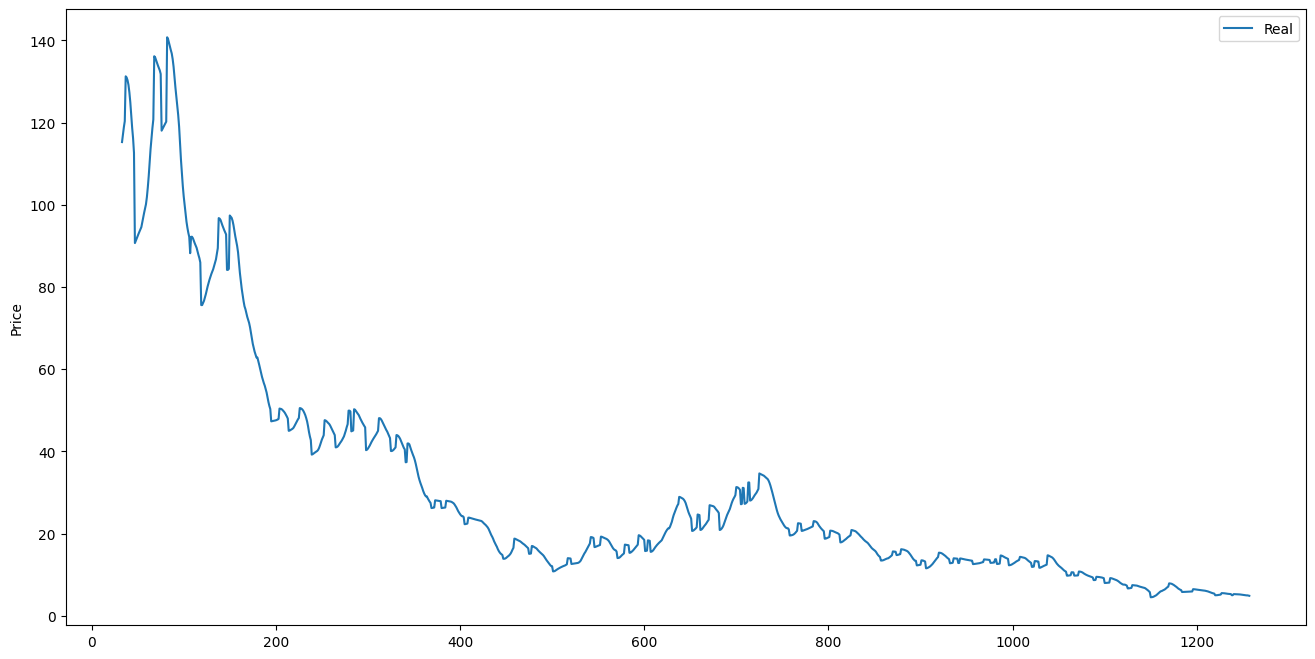

In [35]:
# Plotting Parabolic SAR
plt.figure(figsize=(16,8))
plt.plot(base_A['Parabolic_SAR'], label='Real')
plt.ylabel('Price')
plt.legend()

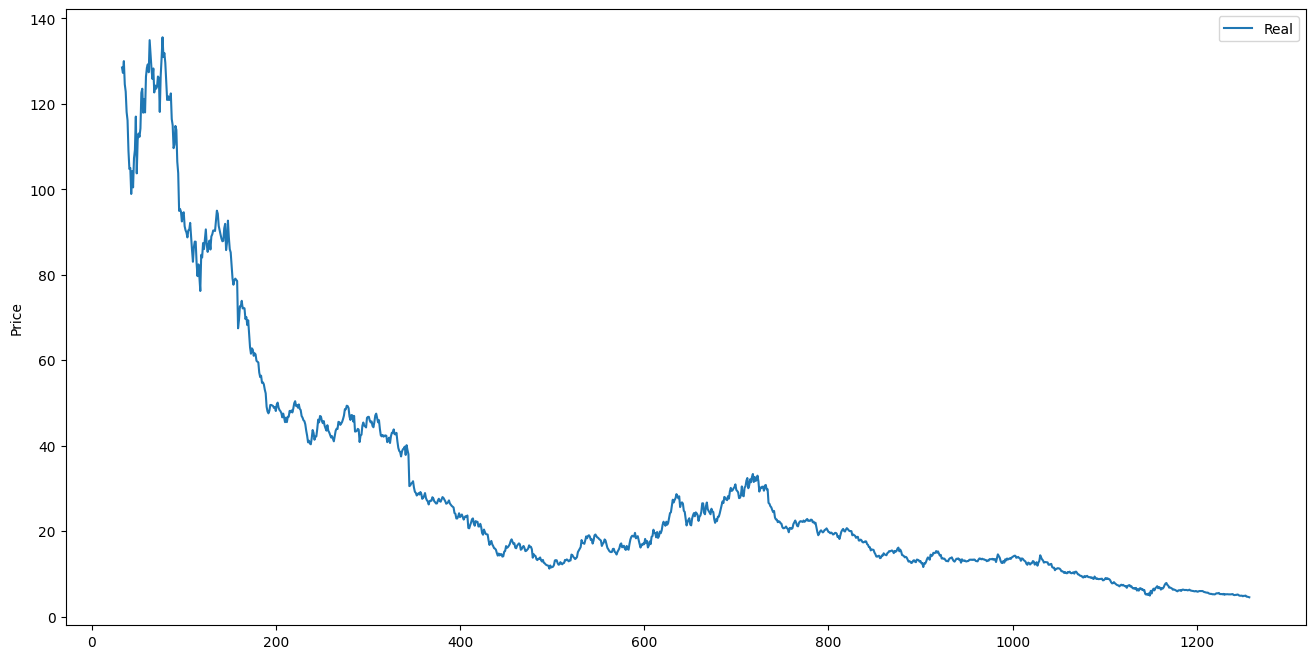

In [36]:
plt.figure(figsize=(16,8))
plt.plot(base_A['Close/Last'], label='Real')
plt.ylabel('Price')
plt.legend()

In [37]:
X_R = base_A['Close/Last'].values
size_R = int(len(X_R) * 0.70)
train_R, test_R = X_R[0:size_R], X_R[size_R:len(X_R)]
history_R = [x_r for x_r in train_R]
forecasts_R = list()

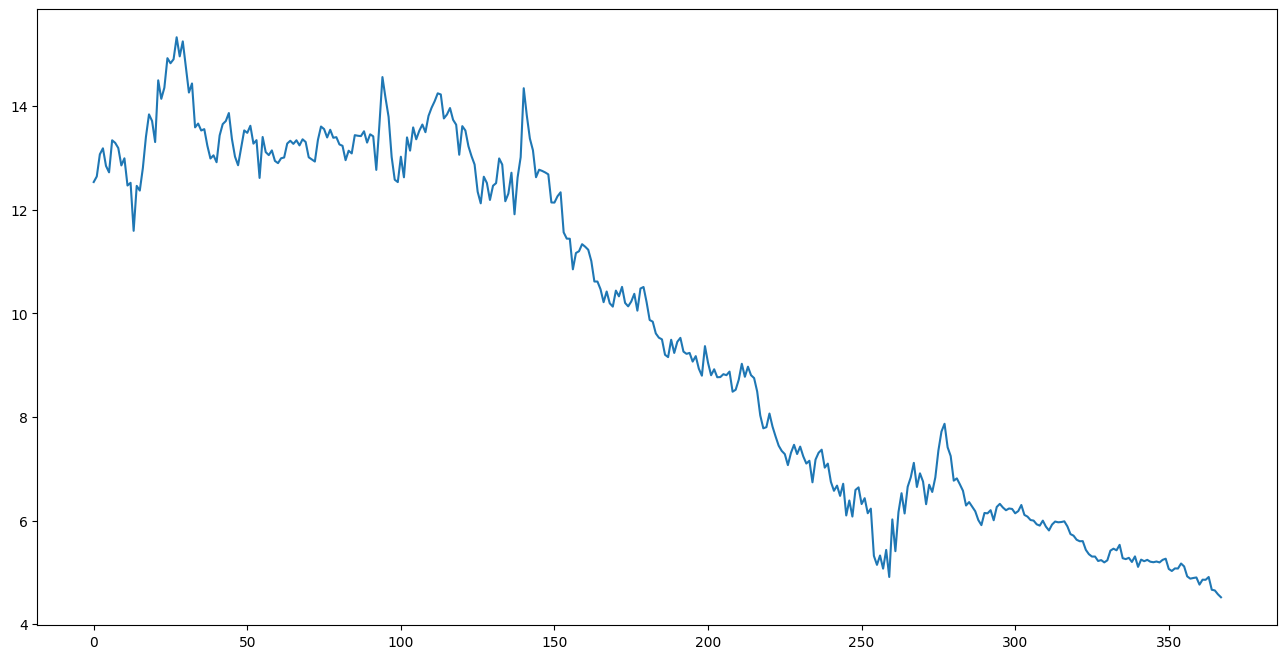

In [38]:
#Test Grafic
plt.figure(figsize=(16, 8))
plt.plot(test_R)
plt.show()

In [39]:
#Addfuller for Parabolic_SAR
result = adfuller(base_A['Parabolic_SAR'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.429277117841055
p-value: 0.13364306334767817


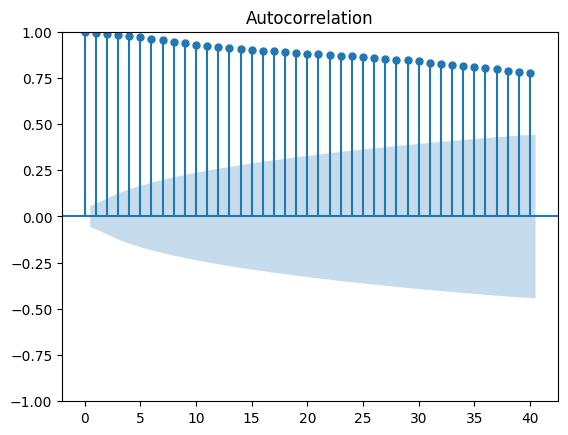

In [40]:
plot_acf(base_A['Parabolic_SAR'], lags=40)
plt.show()

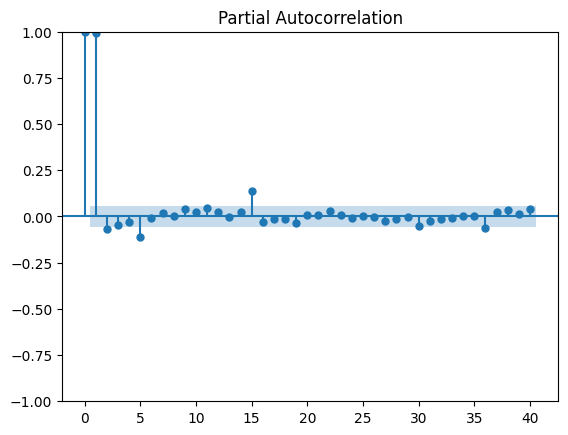

In [41]:
plot_pacf(base_A['Parabolic_SAR'], lags=40)
plt.show()

In [42]:
X = base_A['Parabolic_SAR'].values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
forecasts = list()

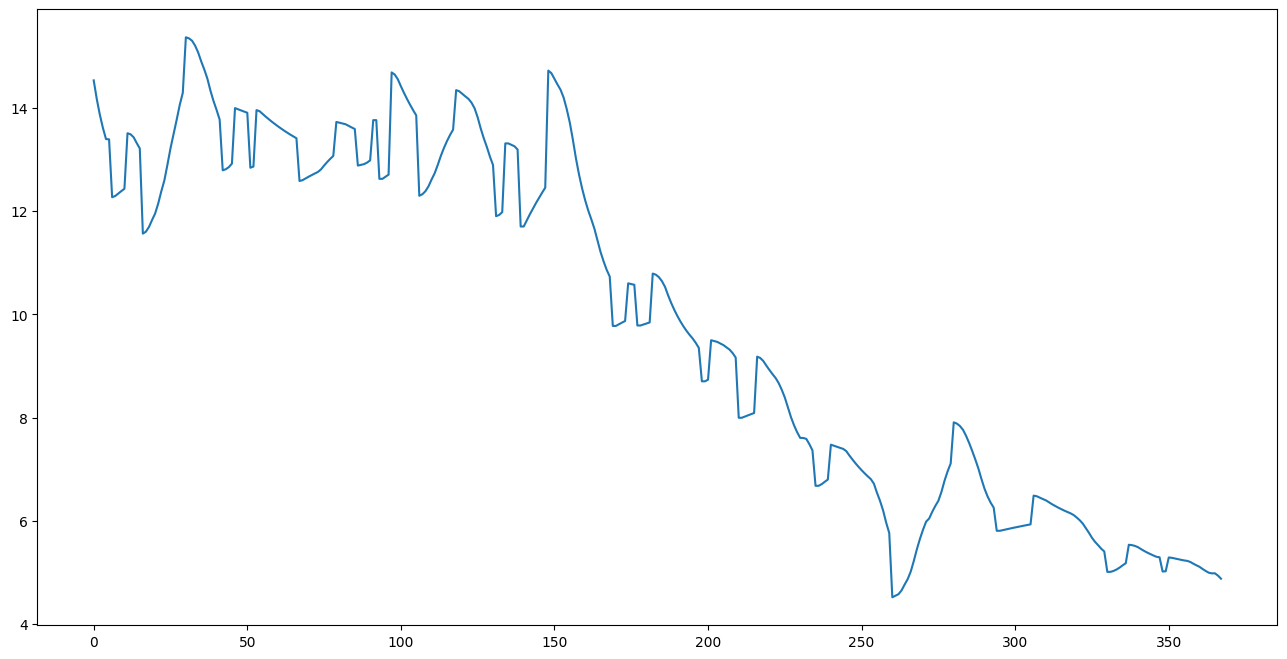

In [43]:
plt.figure(figsize=(16, 8))
plt.plot(test)
plt.show()

In [44]:
# ARIMA
for t in range(len(test)):
    model = ARIMA(history, order=(2, 1, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    forecasts.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f'Expected={yhat}, Observed={obs}')

Expected=14.799350106453055, Observed=14.537034490374273
Expected=14.4307183898127, Observed=14.17462897191439
Expected=14.057742745530945, Observed=13.870208336408087
Expected=13.75733243954059, Observed=13.614495002582792
Expected=13.512205756635627, Observed=13.399695802169546
Expected=13.309969690826959, Observed=13.3945
Expected=13.345905413899215, Observed=12.272
Expected=12.06340780512577, Observed=12.295626
Expected=12.182131516715225, Observed=12.34430096
Expected=12.294808691145416, Observed=12.3910289216
Expected=12.374002545655955, Observed=12.435887764736
Expected=12.435043223557486, Observed=13.5125
Expected=13.688767788156749, Observed=13.491399999999999
Expected=13.588422130178053, Observed=13.434116
Expected=13.473798350164566, Observed=13.32205904
Expected=13.323301339834408, Observed=13.216725497599999
Expected=13.198985697004826, Observed=11.5665
Expected=11.286274081159032, Observed=11.604199999999999
Expected=11.451245585086726, Observed=11.696851999999998
Expecte

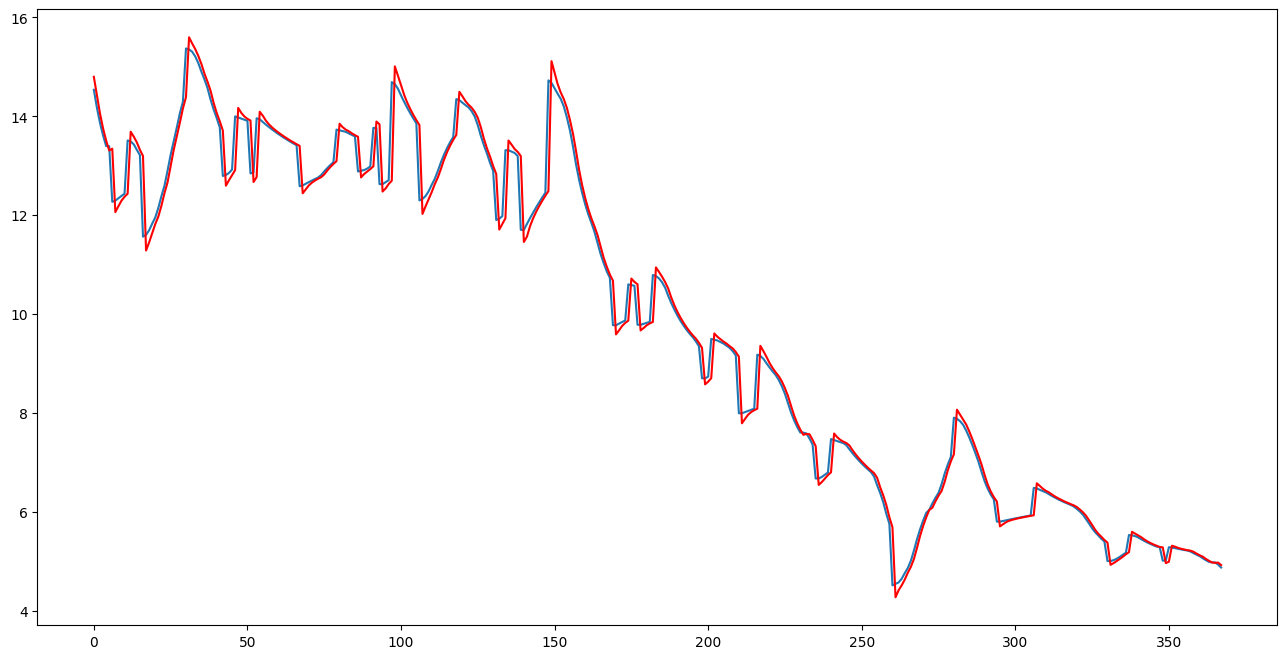

In [45]:
# Test and forecast set
plt.figure(figsize=(16, 8))
plt.plot(test)
plt.plot(forecasts, color='red')
plt.show()

In [46]:
# Ensuring that data is one-dimensional
test = test.ravel()
forecasts = np.array(forecasts).ravel()

In [47]:
# Getting the high, low and close values ​​from the test set for the Parabolic SAR
test_size_A = len(test)

high_test_A = base_A['High'].tail(test_size_A)
low_test_A = base_A['Low'].tail(test_size_A)
close_test_A = base_A['Close/Last'].tail(test_size_A)

In [48]:
print(test.shape)
print(forecasts.shape)

(368,)
(368,)


In [49]:
# Inverse Parabolic SAR formula
def inverse_psar_A(psar_values_A, high_A, low_A, close_A):
    original_prices = []

    original_prices.append(close_A[0])

    for i in range(1, len(psar_values_A)):
        if psar_values_A[i] < close_A[i-1]:
            estimated_price = close_A[i-1] + (close_A[i-1] - psar_values_A[i-1])
            estimated_price = min(estimated_price, high_A[i])
        else:
            estimated_price = close_A[i-1] - (psar_values_A[i-1] - close_A[i-1])
            estimated_price = max(estimated_price, low_A[i])

        original_prices.append(estimated_price)

    return np.array(original_prices)

# Making sure the data is in array format
high_test_A = high_test_A.values if isinstance(high_test_A, pd.Series) else high_test_A
low_test_A = low_test_A.values if isinstance(low_test_A, pd.Series) else low_test_A
close_test_A = close_test_A.values if isinstance(close_test_A, pd.Series) else close_test_A

In [50]:
test_inverted = inverse_psar_A(test, high_test_A, low_test_A, close_test_A)
forecasts_inverted = inverse_psar_A(forecasts, high_test_A, low_test_A, close_test_A)

min_length_R = min(len(test_R), len(forecasts_inverted))
test_R = test_R[:min_length_R]
forecasts_inverted = forecasts_inverted[:min_length_R]

In [51]:
# RMSE
rmse = sqrt(mean_squared_error(test_R, forecasts_inverted))
print(f'RMSE: {rmse}')

# R2 Score
r2 = r2_score(test_R, forecasts_inverted)
print(f'R2 Score: {r2}')

RMSE: 0.29707246216269345
R2 Score: 0.9922004960288178


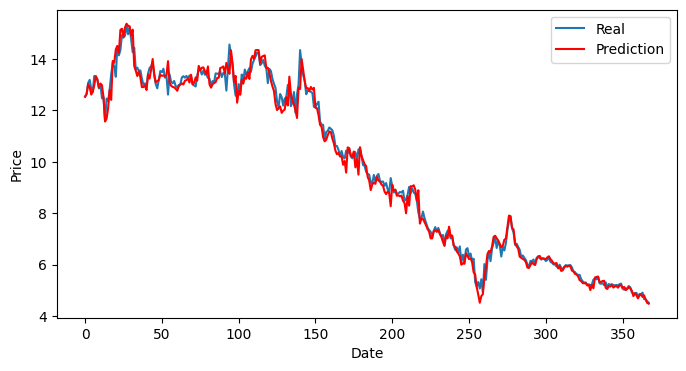

In [52]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(test_R)), test_R, label='Real')
plt.plot(range(len(forecasts_inverted)), forecasts_inverted, label='Prediction', color = 'red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()